In [1]:
from immAGE import *
from utils import *

In [2]:
train_datafiles = [
    "Datasets/adata/panage_pbmc_filter.h5ad",
    "Datasets/adata/GSE161918_healthy.h5ad",
    "Datasets/adata/misc_SeuratObj_fiilter_hc.h5ad",
    "Datasets/adata/GSE157007_pbmc.h5ad",
    "Datasets/adata/GSE174188_CLUES1_adjusted_Healthy.h5ad",
    "Datasets/adata/GSE213516_allcell_HVG.h5ad"
]
print(train_datafiles)

train = load_adata(train_datafiles, 
                   load_celltypist=True, 
                   celltypist_dir='celltypist_by_ref',
                   ctpst_column='predicted_labels')
try:
    sc.pl.umap(train, color=['Group', 'celltype'])
except:
    pass
print('train:', train.shape)

# remove the cells with no age information
train.obs.Age = train.obs.Age.astype('float')
a = train.obs.Age
print(train[a.isnull()].obs['orig.ident'].value_counts())
train = train[a.notnull()]
print('train:', train.shape)

['Datasets/adata/panage_pbmc_filter.h5ad', 'Datasets/adata/GSE161918_healthy.h5ad', 'Datasets/adata/misc_SeuratObj_fiilter_hc.h5ad', 'Datasets/adata/GSE157007_pbmc.h5ad', 'Datasets/adata/GSE174188_CLUES1_adjusted_Healthy.h5ad', 'Datasets/adata/GSE213516_allcell_HVG.h5ad']
Load celltype2 for panage_pbmc_filter.
train: (1060034, 14785)
orig.ident
CHI014    25984
Name: count, dtype: int64
train: (1034050, 14785)


In [3]:
immage = ImmAge(add_gene_features=False)
immage.fit(train, 
           sample_column='orig.ident', 
           celltype_column='celltypist', 
           target_column='Age',
           val_prob=None
           )

save_model(immage, save_dir='./model/fast')

Backend: sklearn
calculate celltype percentages...
  find 177 samples and 27 sub-celltypes.
train Regression predictor...
done.
save model to ./model/fast


['Datasets/adata/chuanqi_after_filter.h5ad', 'Datasets/adata/chuanqi_predicted.h5ad', 'Datasets/adata/disco_blood_v1.h5ad', 'Datasets/adata/GSE174188_CLUES1_adjusted_SLE.h5ad']
test: (944609, 14011)


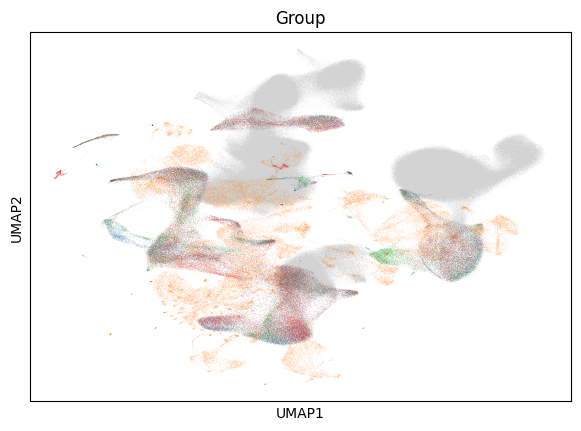

In [4]:
test_datafiles = [
    "Datasets/adata/chuanqi_after_filter.h5ad",
    "Datasets/adata/chuanqi_predicted.h5ad", 
    "Datasets/adata/disco_blood_v1.h5ad",
    "Datasets/adata/GSE174188_CLUES1_adjusted_SLE.h5ad",
]

test_datafiles = np.array(test_datafiles)
test_datafiles = test_datafiles.tolist() 
print(test_datafiles)

test = load_adata(test_datafiles, 
                  load_celltypist=True, 
                  celltypist_dir='celltypist_by_ref',
                  ctpst_column='predicted_labels')
try:
    sc.pl.umap(test, color=['Group', 'celltype'])
except:
    pass

pd.isnull(test.obs.Age).sum()
test = test[pd.notnull(test.obs.Age)]
print('test:', test.shape)

calculate celltype percentages...
  find 225 samples and 27 sub-celltypes.
predicting...
done.
Results on test set:
           Predicted age  Actual age
P7             30.140347         1.6
P8             23.670786         5.4
P9             12.648332         3.3
P10            22.358900         2.1
P11            31.673664         1.9
...                  ...         ...
1045_1045      67.298888        31.0
1337_1337      55.592974        60.0
FLARE005       46.301484        26.0
1597_1597      38.828425        36.0
1493_1493      44.838785        34.0

[225 rows x 2 columns]
MAE = 11.58, Accuracy within 10 years = 0.52, Pearson correlation = 0.66


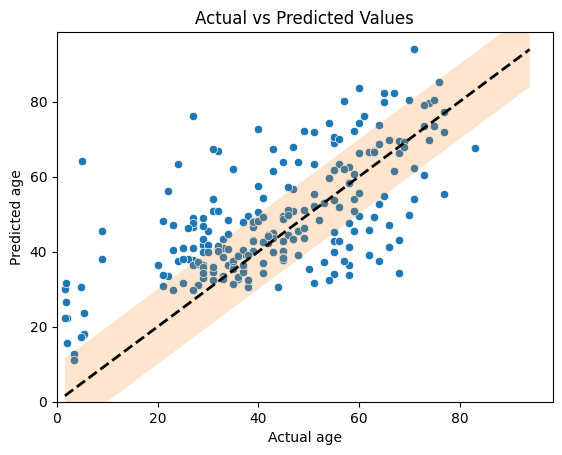

In [5]:
immage = load_model(save_dir='./model/fast')
pred_test = immage.predict(test, 
                           sample_column='orig.ident',
                           celltype_column='celltypist'
                           )
tmp = pred_test["predicted_Age"]
tmp[tmp>110] = 110
pred_test["predicted_Age"] = tmp

test_sample_labels = immage.get_sample_labels(test, sample_column='orig.ident', target_column='Age')
compare = pd.concat([pred_test["predicted_Age"], test_sample_labels], axis=1)
compare.columns = ['Predicted age', 'Actual age']
print('Results on test set:')
print(compare)

eval_prediction(compare['Actual age'], compare['Predicted age'])
plot_pred_results(compare, band_width=10)